In [1]:
import numpy as np
from numpy.fft import fft, ifft, irfft, rfft
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
       
import hifiscan as hifi
audio = hifi.Audio()

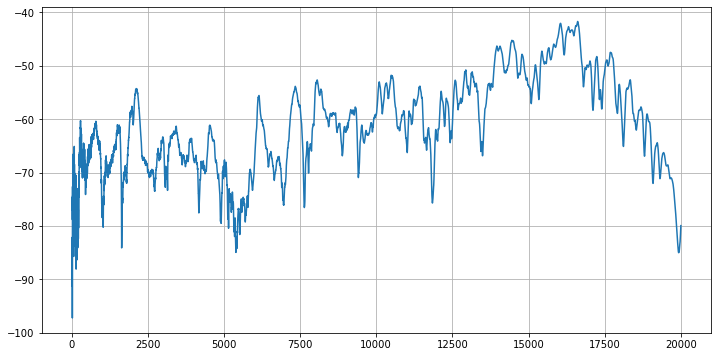

In [2]:
# Spectrum measurement
analyzer = hifi.Analyzer(f0=20, f1=20000, secs=1, rate=audio.rate, ampl=0.4)
audio.play(analyzer.chirp)
async for recording in audio.record():
    if analyzer.findMatch(recording):
        break
    if analyzer.timedOut():
        raise Exception('Timeout')
        
spectrum = analyzer.spectrum(smoothing=10)
plt.plot(*spectrum)
plt.grid()

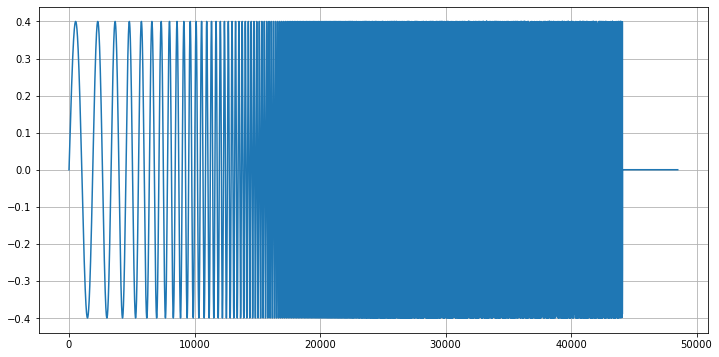

In [3]:
# Input stimulus x
plt.plot(analyzer.x)
plt.grid()

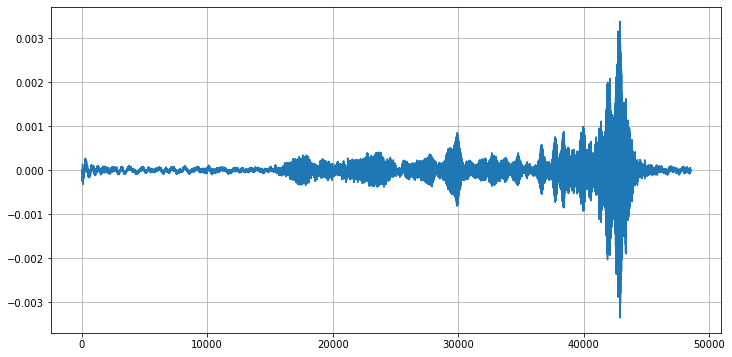

In [4]:
# Output response y
plt.plot(analyzer.y)
plt.grid()

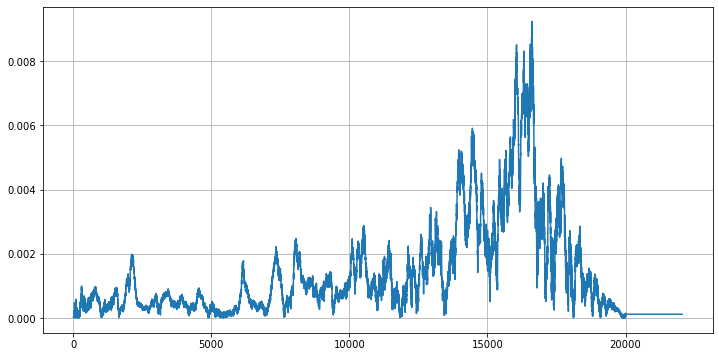

In [5]:
# Transfer function H = X / Y, with X = FT(x), Y = FT(y) and FT the Fourier Transform
# f, H = analyzer.H()
f, H2 = analyzer.H2(smoothing=0)
H = H2 ** 0.5
plt.plot(f, H)
plt.grid()

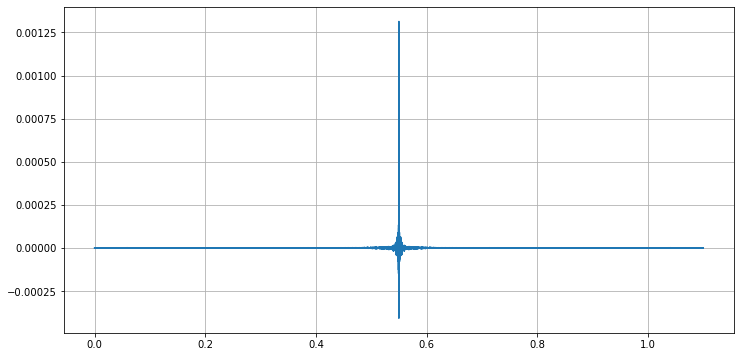

In [6]:
# Impulse response h = IFT(H), with IFT the Inverse Fourier Transform
t, h = analyzer.h()
plt.plot(t, h)
plt.grid()
audio.play(h / np.abs(h).max())

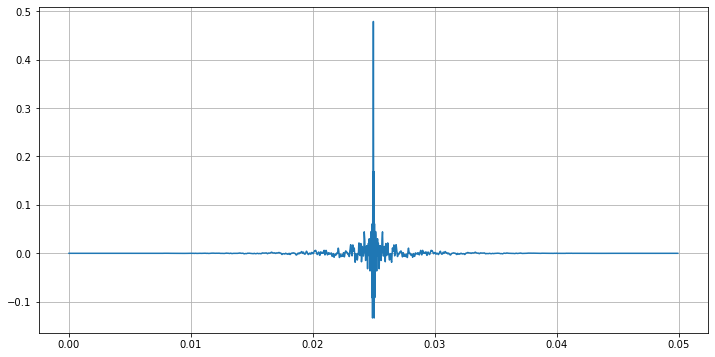

In [7]:
# Inverse impulse response h_inv = IFT(1 / H)
t, h_inv = analyzer.h_inv(
    secs=0.05,
    dbRange=30,
    kaiserBeta=5,
    smoothing=15)
plt.plot(t, h_inv)
plt.grid()
# audio.play(h_inv / np.abs(h_inv).max())
# hifi.write_wav('IR.wav', [h_inv, h_inv], audio.rate)

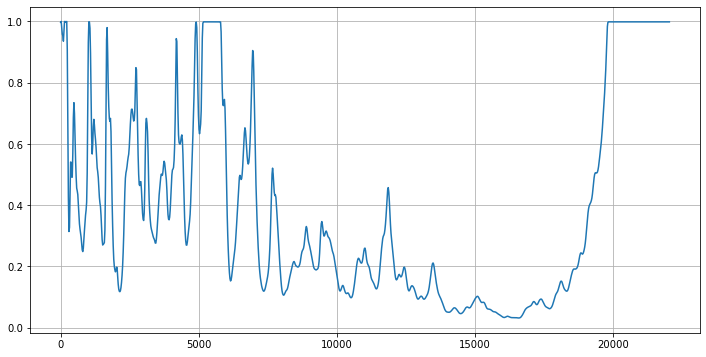

In [8]:
# Correction factor that h_inv applies for every frequency
corrFactor = analyzer.correctionFactor(h_inv)
plt.plot(*corrFactor)
plt.grid()

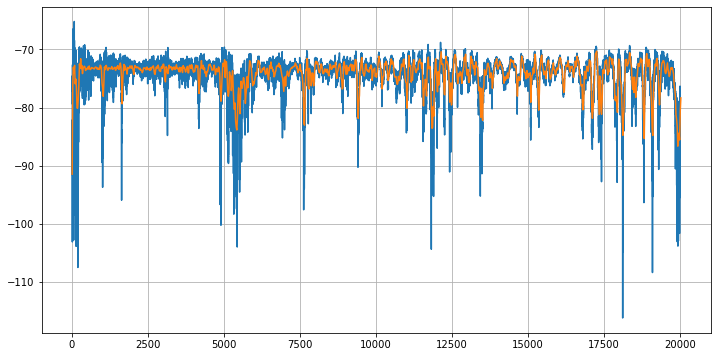

In [9]:
# Expected corrected spectrum
sp1, sp2 = analyzer.correctedSpectrum(corrFactor)
plt.plot(*sp1)
plt.plot(*sp2)
plt.grid()

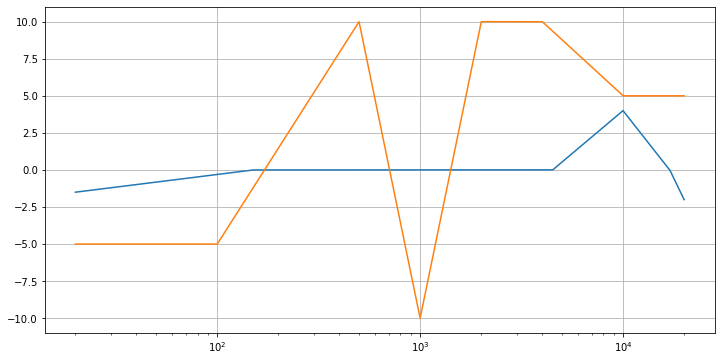

In [10]:
# Setting mic calibration or target curve
calibration = [(20, -1.5), (150, 0), (4500, 0), (10000, 4), (17000, 0), (20000, -2)]
target = [(100, -5), (500, 10), (1000, -10), (2000, 10), (4000, 10), (10000, 5)]
#target = hifi.read_correction('house.txt')
analyzer = hifi.Analyzer(
    f0=20, f1=20000, secs=1, rate=audio.rate, ampl=0.4,
    calibration=calibration, target=target)

# Interpolated calibration/target curves
freq = analyzer.frequency()
cal = analyzer.calibration()
tgt = analyzer.target()
r = analyzer.freqRange()
plt.semilogx(freq[r], cal[r])
plt.semilogx(freq[r], tgt[r])
plt.grid()

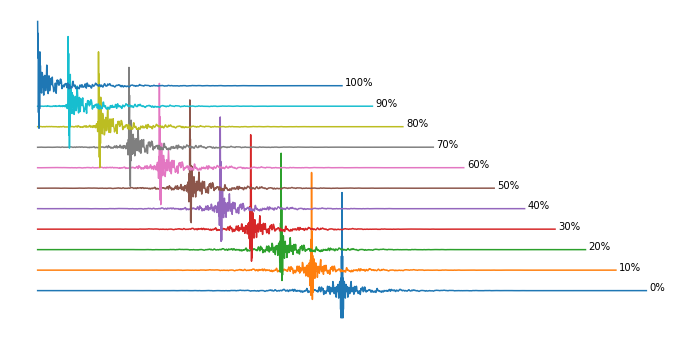

In [11]:
# Waveform as a function of causality
for causality in range(0, 110, 10):
    offset = causality / 100
    h2 = offset + hifi.transform_causality(h_inv, causality / 100)
    plt.plot(h2)
    plt.text(h2.size + 10, offset, f'{causality}%')
plt.axis('off');

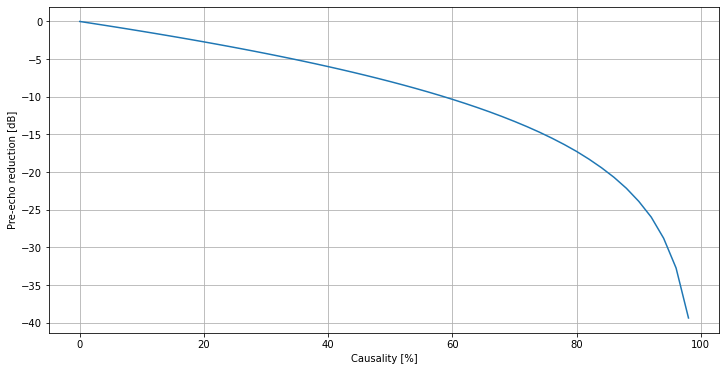

In [12]:
# dB reduction of pre-echo as a function of causality
causalities = range(0, 100, 2)
dbs = np.empty_like(causalities, 'd')
for i, causality in enumerate(causalities):
    h2 = hifi.transform_causality(h_inv, causality / 100)
    p = h2.argmax()
    caus = (h2[p:] ** 2).sum()
    acaus = (h2[:p] ** 2).sum()
    dbs[i] = 10 * np.log10(acaus / caus)
dbs -= dbs[0]
plt.plot(causalities, dbs)
plt.grid()
plt.xlabel('Causality [%]')
plt.ylabel('Pre-echo reduction [dB]');

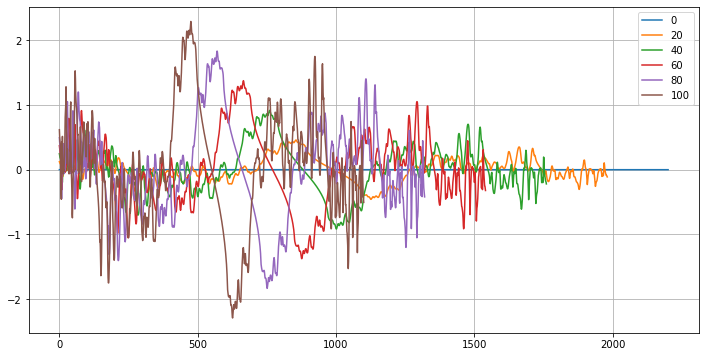

In [13]:
# Phase distortion as a function of causality
from scipy import signal
for causality in range(0, 110, 20):
    h2 = hifi.transform_causality(h_inv, causality / 100)
    phase = signal.detrend(np.unwrap(np.angle(fft(h2))))
    plt.plot(phase, label=causality)
plt.legend()
plt.grid()

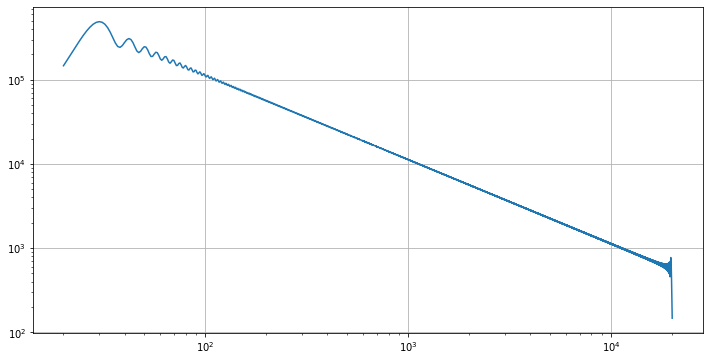

In [14]:
# Power distribution of the chirp
x = analyzer.chirp
y = np.abs(np.fft.rfft(x)) ** 2
f = np.linspace(0, analyzer.rate / 2, y.size)
r = analyzer.freqRange(f.size)
plt.loglog(f[r], y[r])
plt.grid()

In [15]:
# Play some tones
tones = [0.4 * hifi.tone(440 * i, 0.1, audio.rate) for i in range(1, 12)]
for tone in tones:
    audio.play(tone)

In [16]:
# Create a missing fundamental of 20 Hz
# https://en.wikipedia.org/wiki/Missing_fundamental
tones = [hifi.tone(20 * i, 2, audio.rate) / i for i in range(6, 22)]
for chord in np.cumsum(tones[::-1], 0):
    chord /= np.abs(chord).max()
    audio.play(chord)

In [17]:
audio.close()